In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

from numba import jit
from ultranest import ReactiveNestedSampler
from ultranest.plot import PredictionBand

In [2]:
df = pd.read_csv("data.csv")

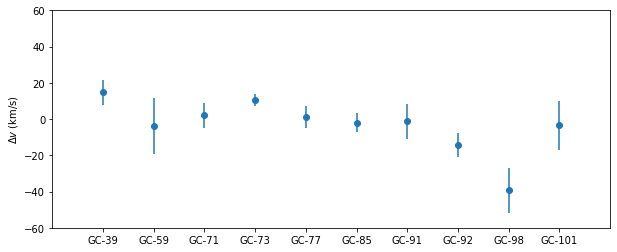

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(df.index, df["v"], yerr=df["v_err"], marker="o", linestyle="none")
ax.set_xticks(df.index)
ax.set_xticklabels(df["id"])
ax.set_xlim([-1, 10])
ax.set_ylim([-60, 60])
ax.set_ylabel(r"$\Delta v$ (km/s)")
plt.show()

In [4]:
@jit(nopython=True)
def expect(mu0, sigma0, mu1, sigma1):
    x2 = (mu1 - mu0)**2
    s2 = sigma0**2 + sigma1**2
    return np.exp(-0.5 * x2 / s2) / np.sqrt(2 * np.pi * s2)

# quick test against scipy
def test_expect(mu0, sigma0, mu1, sigma1):
    d0 = scipy.stats.norm(mu0, sigma0)
    d1 = scipy.stats.norm(mu1, sigma1)
    reference_value = d0.expect(d1.pdf)
    test_value = expect(mu0, sigma0, mu1, sigma1)
    return np.isclose(test_value, reference_value)
assert test_expect(1, 10, 5, 50)

In [5]:
def uniform_prior(x, x0, x1):
    return x0 + (x1 - x0) * x

def prior_transform(cube):
    params = cube.copy()
    params[0] = uniform_prior(cube[0], -50, 50) # mean
    params[1] = uniform_prior(cube[1], 0.1, 50) # log_sigma
    return params

def log_likelihood(params, v_meas=df["v"], v_meas_err=df["v_err"]):
    mean, log_sigma = params
    sigma = np.exp(log_sigma)
    
    value = 0
    for vi, vi_err in zip(v_meas, v_meas_err):
        value += np.log(expect(mean, sigma, vi, vi_err))
        
    return value

In [6]:
#%timeit log_likelihood([0, 1])

In [7]:
sampler = ReactiveNestedSampler(["mean", "log_sigma"], log_likelihood, prior_transform)
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-40.0061..-40.0059]*| it/evals=4293/6034 eff=76.1981% N=400  
[ultranest] Likelihood function evaluations: 6059
[ultranest]   logZ = -46.16 +- 0.06399
[ultranest] Effective samples strategy satisfied (ESS = 1687.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.

logZ = -46.182 +- 0.181
  single instance: logZ = -46.182 +- 0.113
  bootstrapped   : logZ = -46.165 +- 0.180
  tail           : logZ = +- 0.010

    mean                -1.1 +- 4.5
    log_sigma           2.19 +- 0.52


In [8]:
#sampler.plot_run()

In [9]:
#sampler.plot_trace()

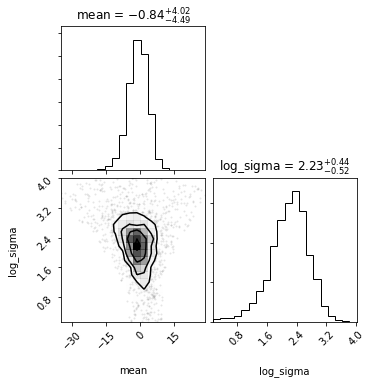

In [10]:
sampler.plot_corner()

In [11]:
mean, log_sigma = np.transpose(result["samples"])
sigma = np.exp(log_sigma)

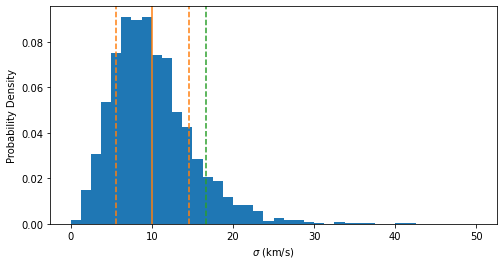

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(sigma, bins=np.linspace(0, 50, 41), density=True)
ax.axvline(np.mean(sigma), color="C1")
ax.axvline(np.percentile(sigma, 16), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 84), color="C1", linestyle="--")
ax.axvline(np.percentile(sigma, 90), color="C2", linestyle="--")
ax.set_xlabel(r"$\sigma$ (km/s)")
ax.set_ylabel("Probability Density")
plt.show()

In [13]:
print(f"sigma < {np.percentile(sigma, 90):.2f} km/s at 90% confidence")

sigma < 16.66 km/s at 90% confidence


In [14]:
print(f"sigma < 10 km/s at {scipy.stats.percentileofscore(sigma, 10):.0f}% confidence")

sigma < 10 km/s at 56% confidence


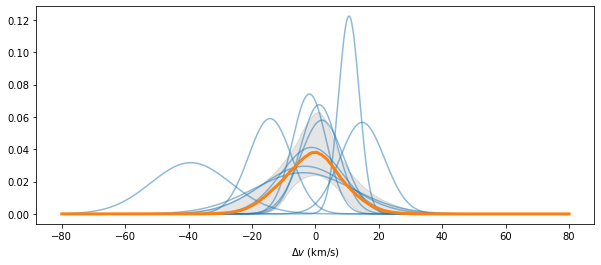

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

v = np.linspace(-80, 80, 500)
for _, d in df.iterrows():
    ax.plot(v, scipy.stats.norm(d["v"], d["v_err"]).pdf(v), color="C0", alpha=0.5)

band = PredictionBand(v)
for loc, scale in zip(mean, sigma):
    band.add(scipy.stats.norm(loc, scale).pdf(v))

band.shade(color="black", alpha=0.1)
band.line(color="C1", linewidth=3)

ax.set_xlabel(r"$\Delta v$ (km/s)")
plt.show()